In [1]:
import pandas, numpy, seaborn, umap
import scipy, scipy.signal
import sklearn, sklearn.cluster
import MulticoreTSNE

In [2]:
scipy.__version__

'1.7.3'

In [2]:
import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.family':'sans-serif',
                            'font.size':20, 
                            'xtick.labelsize':30, 
                            'ytick.labelsize':30, 
                            'figure.figsize':(16, 9), 
                            'axes.labelsize':40})

# user-defined variables

In [3]:
expression_file = '/home/adrian/databases/gtex/selected_expression.tsv'
output_dir = '/home/adrian/scratch/'

In [4]:
iso1 = 'ENST00000354449.7'
iso2 = 'ENST00000354956.9'

# read data

In [5]:
%%time
selected_expression = pandas.read_csv(expression_file, index_col=0, sep='\t')
print(selected_expression.shape)
selected_expression.head()

(46490, 4385)
CPU times: user 29 s, sys: 1.09 s, total: 30.1 s
Wall time: 30.1 s


,GTEX-S4Q7-0003-SM-3NM8M,GTEX-QV31-1626-SM-2S1QC,GTEX-13OW5-0626-SM-5J2N2,GTEX-ZPCL-0126-SM-4WWC8,GTEX-X88G-0426-SM-47JZ5,GTEX-1399S-1726-SM-5L3DI,GTEX-ZF29-0926-SM-4WKFZ,GTEX-WHPG-0226-SM-3NMB9,GTEX-P44H-0526-SM-2XCF1,GTEX-11ONC-2326-SM-5HL6P,...,GTEX-144GO-0126-SM-5LUAO,GTEX-1313W-1626-SM-5J1OE,GTEX-12ZZY-1526-SM-5LZWF,GTEX-QMRM-0826-SM-3NB33,GTEX-OOBK-2626-SM-2HMKY,GTEX-1117F-2826-SM-5GZXL,GTEX-11ZTS-3326-SM-5LU9Y,GTEX-ZA64-2126-SM-5Q5A8,GTEX-Q2AG-2826-SM-2HMJQ,GTEX-XV7Q-0426-SM-4BRVN
sample,,,,,,,,,,,,,,,,,,,,,
ENST00000625998.2,2.172597,2.098120,0.604361,1.012243,2.112940,1.282651,2.350597,1.055977,2.652690,2.268121,...,0.979851,2.130198,1.992097,1.513298,1.761416,2.140628,2.460868,1.539885,3.384828,2.148756e+00
ENST00000583693.5,1.679476,1.659720,2.343766,2.182024,1.608522,2.342481,1.919266,2.462014,1.794654,1.688779,...,2.027438,1.520067,1.725912,2.402364,2.313324,1.886362,3.031236,2.084875,3.180704,1.991199e+00
ENST00000012134.6,0.028054,1.528813,1.308149,0.799196,2.200149,1.650502,1.646210,2.311007,1.437005,2.369605,...,1.576889,1.827558,2.260518,1.542512,2.087475,1.687606,1.888114,1.929434,3.288411,1.385126e+00
ENST00000403263.5,2.737514,2.433423,2.221165,2.084570,2.304542,2.238873,2.688859,2.615937,3.291015,2.220693,...,2.220222,2.060171,2.130275,2.778681,1.937410,2.314922,2.136376,2.615435,2.532466,1.944068e+00
ENST00000449352.6,1.695411,2.800497,2.215746,2.359610,2.831991,2.112632,2.839560,2.607822,1.759019,2.999159,...,3.785498,1.353480,2.671217,2.489579,1.660130,1.744530,3.022813,2.252766,1.301894,8.428712e-08


# quantile normalization

In [6]:
%%time
#
# quantile normalization 
# taken from https://cmdlinetips.com/2020/06/computing-quantile-normalization-in-python/
#

# step 1/3: sorting sample values
df_sorted = pandas.DataFrame(numpy.sort(selected_expression.values, axis=0), index=selected_expression.index, columns=selected_expression.columns)
# step 2/3: averaging rank values across samples
df_mean = df_sorted.mean(axis=1)
df_mean.index = numpy.arange(1, len(df_mean) + 1)
# step 3/3: re-ordering samples
qndf = selected_expression.rank(method="min").stack().astype(int).map(df_mean).unstack()

CPU times: user 1min, sys: 6.19 s, total: 1min 6s
Wall time: 1min 6s


14.553924904476192
4385


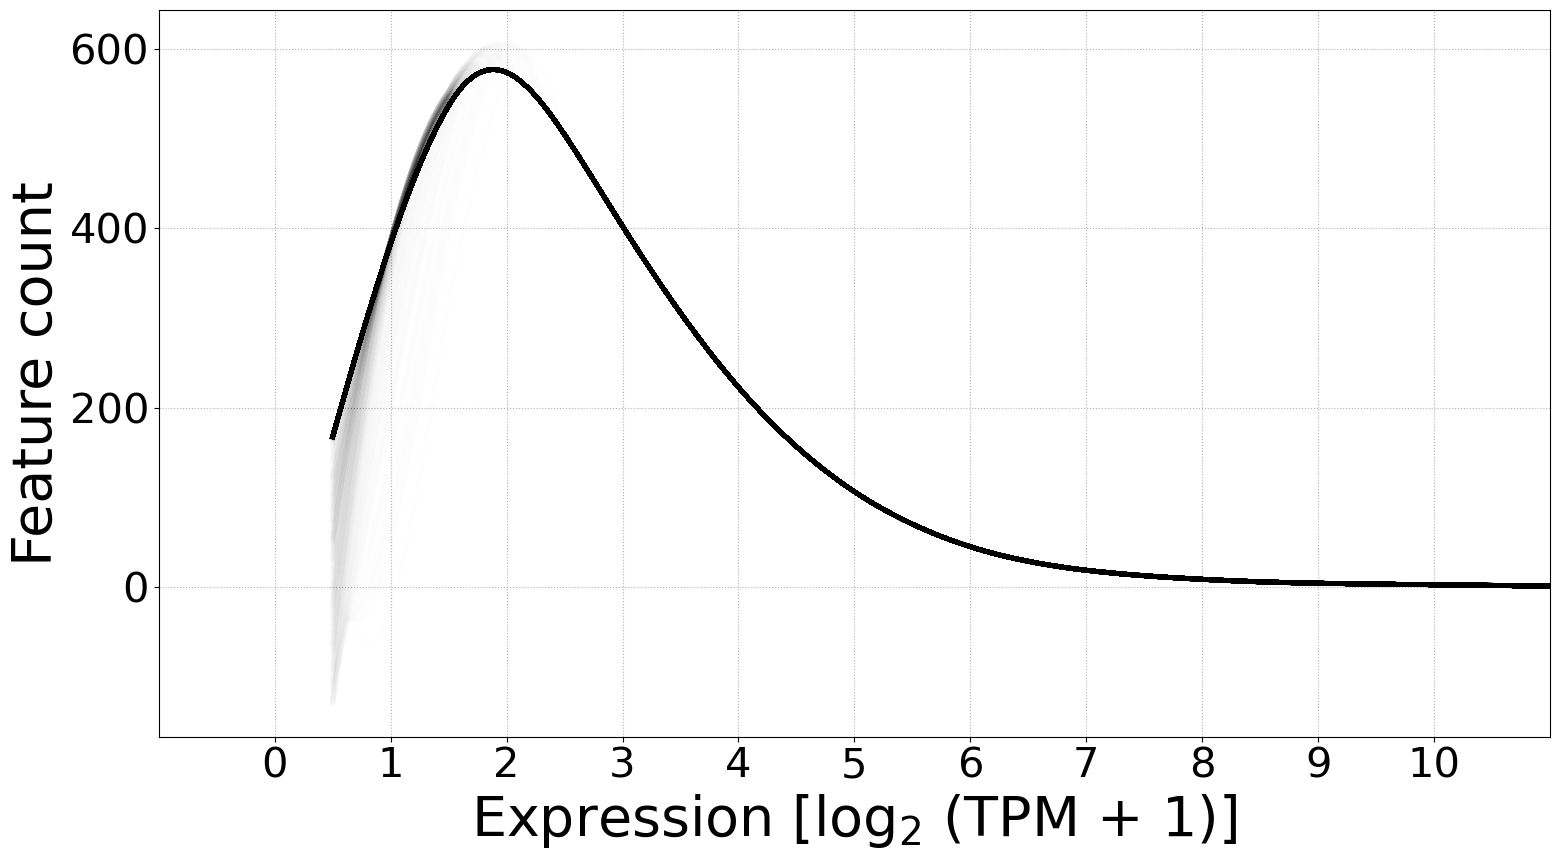

In [7]:
found_max = 15
resolution = 25
number_of_bins = found_max * resolution
absolute_max = 0
margin = int(resolution/2)

most_likely_expressions = []

selected_samples = []

for sample in qndf.columns:
        
    expression_values = qndf.loc[:, sample]
    
    # histogram
    hist, bin_edges = numpy.histogram(expression_values, bins=number_of_bins, range=(0, found_max))
    half_bin = (bin_edges[1] - bin_edges[0])/2
    x = bin_edges + half_bin
    x = x[:-1]
    
    # curve fitting
    plotting_x = x[margin:-margin]
    plotting_hist = hist[margin:-margin]
    yhat = scipy.signal.savgol_filter(plotting_hist, 51, 3)
    
    # determine most likely expression
    most_likely_expression = x[numpy.argmax(yhat)]
    most_likely_expressions.append(most_likely_expression)
    
    # sample selection
    if 1 <= most_likely_expression <= 2:
        selected_samples.append(sample)
    
    # plotting
    matplotlib.pyplot.plot(plotting_x, yhat, '-', lw=4, alpha=1/300, color='black')
    
    # check
    if numpy.max(expression_values) > absolute_max:
        absolute_max = numpy.max(expression_values)

# check print
print(absolute_max)
print(len(selected_samples))

matplotlib.pyplot.xlim(-1, 11)                  
matplotlib.pyplot.xticks(range(0, 10+1))
matplotlib.pyplot.xlabel('Expression [log$_2$ (TPM + 1)]')
matplotlib.pyplot.ylabel('Feature count')
matplotlib.pyplot.grid(ls=':')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

In [8]:
%%time
tqndf = qndf.transpose()
tqndf.to_csv('{}/tqndf.tsv'.format(output_dir), sep='\t')

CPU times: user 3min 45s, sys: 1.6 s, total: 3min 46s
Wall time: 3min 47s


# z-score

In [9]:
zscore_df = scipy.stats.zscore(qndf, axis=1)
zscore_df.std(axis=1)

sample
ENST00000625998.2    1.000114
ENST00000583693.5    1.000114
ENST00000012134.6    1.000114
ENST00000403263.5    1.000114
ENST00000449352.6    1.000114
                       ...   
ENST00000470412.5    1.000114
ENST00000469534.1    1.000114
ENST00000507412.1    1.000114
ENST00000568351.1    1.000114
ENST00000491408.1    1.000114
Length: 46490, dtype: float64

In [10]:
print(zscore_df.max().max())
print(zscore_df.min().min())

15.804689630376652
-18.18179087330121


In [11]:
%%time
zscore_df.to_csv('{}/zscore.tsv'.format(output_dir), sep='\t')

CPU times: user 2min 25s, sys: 1.7 s, total: 2min 27s
Wall time: 2min 27s


# exploratory visualization

## heatmap

In [12]:
zscore_df.rename_axis('Transcripts', inplace=True)
zscore_df.rename_axis('Samples', axis='columns', inplace=True)
print(zscore_df.shape)
zscore_df

(46490, 4385)


Samples,GTEX-S4Q7-0003-SM-3NM8M,GTEX-QV31-1626-SM-2S1QC,GTEX-13OW5-0626-SM-5J2N2,GTEX-ZPCL-0126-SM-4WWC8,GTEX-X88G-0426-SM-47JZ5,GTEX-1399S-1726-SM-5L3DI,GTEX-ZF29-0926-SM-4WKFZ,GTEX-WHPG-0226-SM-3NMB9,GTEX-P44H-0526-SM-2XCF1,GTEX-11ONC-2326-SM-5HL6P,...,GTEX-144GO-0126-SM-5LUAO,GTEX-1313W-1626-SM-5J1OE,GTEX-12ZZY-1526-SM-5LZWF,GTEX-QMRM-0826-SM-3NB33,GTEX-OOBK-2626-SM-2HMKY,GTEX-1117F-2826-SM-5GZXL,GTEX-11ZTS-3326-SM-5LU9Y,GTEX-ZA64-2126-SM-5Q5A8,GTEX-Q2AG-2826-SM-2HMJQ,GTEX-XV7Q-0426-SM-4BRVN
Transcripts,,,,,,,,,,,,,,,,,,,,,
ENST00000625998.2,0.201517,0.036483,-2.678424,-1.913425,-0.196345,-1.555508,0.632833,-2.103236,0.078840,-0.065244,...,-1.851241,-0.028877,0.104782,-1.695963,-0.742029,-0.091520,0.168139,-1.158666,1.260004,-0.326773
ENST00000583693.5,-0.157536,-0.387785,0.348795,0.398806,-1.129253,0.687884,0.582988,0.557330,-1.350953,-1.209634,...,-0.173132,-1.156789,-0.024576,0.025022,0.682437,-0.352807,2.375209,-0.067561,2.293898,-0.429855
ENST00000012134.6,-1.858374,-0.230357,-1.101552,-1.678630,0.351186,-0.498028,0.051742,0.196520,-0.976582,0.499852,...,-0.537618,-0.037223,0.879018,-1.132267,0.183165,-0.377856,-0.203226,-0.120816,1.457736,-0.879079
ENST00000403263.5,1.824639,0.803760,-0.939061,-0.804629,-0.097733,-0.456441,2.261055,0.277584,2.031893,-0.600251,...,-0.607003,-0.588132,0.423970,0.384197,-1.341820,0.128895,-0.985785,0.765705,0.074665,-1.675408
ENST00000449352.6,-0.714858,0.391161,-0.649496,-0.251540,0.275481,-0.622791,0.703996,-0.210234,-1.321825,0.461139,...,1.286650,-1.422651,0.540561,-0.532098,-1.155870,-1.024148,0.439395,-0.473859,-1.347097,-2.987846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENST00000470412.5,-0.343926,-0.700203,1.493895,-0.896921,-0.323228,1.640890,0.597571,-0.869830,0.848136,0.116067,...,-0.357460,-0.206770,-1.171861,1.835204,-0.954903,0.083981,-1.160399,0.784913,-0.591934,2.417448
ENST00000469534.1,-0.658335,-0.508709,-1.181746,-1.279740,-0.498626,-0.508271,0.492896,-0.938374,3.573323,1.974929,...,0.091804,1.200977,-0.295721,-0.439505,-1.144647,0.641427,-0.829288,1.896179,-1.635945,-1.402662
ENST00000507412.1,1.256783,1.699418,-0.896584,-0.779208,1.566538,-0.102175,-1.142376,-0.776279,0.097170,-0.791390,...,-0.567447,-0.741137,-0.738446,0.601353,-0.462320,0.090812,0.350678,0.463214,0.326356,2.009768


In [13]:
# reduction of 10 runs for 68 CPU s
# reduction of 3 runs for 7 CPU min
# reduction of 1 runs for 52 CPU min

print(zscore_df.shape)

reduction = 1
test = zscore_df.iloc[:int(zscore_df.shape[0]/reduction), :] 

print(test.shape)
test.tail()

(46490, 4385)
(46490, 4385)


Samples,GTEX-S4Q7-0003-SM-3NM8M,GTEX-QV31-1626-SM-2S1QC,GTEX-13OW5-0626-SM-5J2N2,GTEX-ZPCL-0126-SM-4WWC8,GTEX-X88G-0426-SM-47JZ5,GTEX-1399S-1726-SM-5L3DI,GTEX-ZF29-0926-SM-4WKFZ,GTEX-WHPG-0226-SM-3NMB9,GTEX-P44H-0526-SM-2XCF1,GTEX-11ONC-2326-SM-5HL6P,...,GTEX-144GO-0126-SM-5LUAO,GTEX-1313W-1626-SM-5J1OE,GTEX-12ZZY-1526-SM-5LZWF,GTEX-QMRM-0826-SM-3NB33,GTEX-OOBK-2626-SM-2HMKY,GTEX-1117F-2826-SM-5GZXL,GTEX-11ZTS-3326-SM-5LU9Y,GTEX-ZA64-2126-SM-5Q5A8,GTEX-Q2AG-2826-SM-2HMJQ,GTEX-XV7Q-0426-SM-4BRVN
Transcripts,,,,,,,,,,,,,,,,,,,,,
ENST00000470412.5,-0.343926,-0.700203,1.493895,-0.896921,-0.323228,1.640890,0.597571,-0.869830,0.848136,0.116067,...,-0.357460,-0.206770,-1.171861,1.835204,-0.954903,0.083981,-1.160399,0.784913,-0.591934,2.417448
ENST00000469534.1,-0.658335,-0.508709,-1.181746,-1.279740,-0.498626,-0.508271,0.492896,-0.938374,3.573323,1.974929,...,0.091804,1.200977,-0.295721,-0.439505,-1.144647,0.641427,-0.829288,1.896179,-1.635945,-1.402662
ENST00000507412.1,1.256783,1.699418,-0.896584,-0.779208,1.566538,-0.102175,-1.142376,-0.776279,0.097170,-0.791390,...,-0.567447,-0.741137,-0.738446,0.601353,-0.462320,0.090812,0.350678,0.463214,0.326356,2.009768
ENST00000568351.1,-1.172953,0.246373,0.766133,0.853352,-0.234204,0.774586,0.211088,1.161617,-1.372284,-0.044015,...,1.313564,-0.194610,0.288484,0.332878,1.186967,0.236284,-0.949662,-0.896561,-0.750159,-0.302144
ENST00000491408.1,-0.713929,0.883018,-0.625723,-0.343984,-0.327609,-0.707473,0.368435,0.039041,1.781173,2.079301,...,0.740145,-0.105044,-0.420568,0.042424,-0.398806,0.550752,0.069222,0.863807,-2.074857,-0.859024


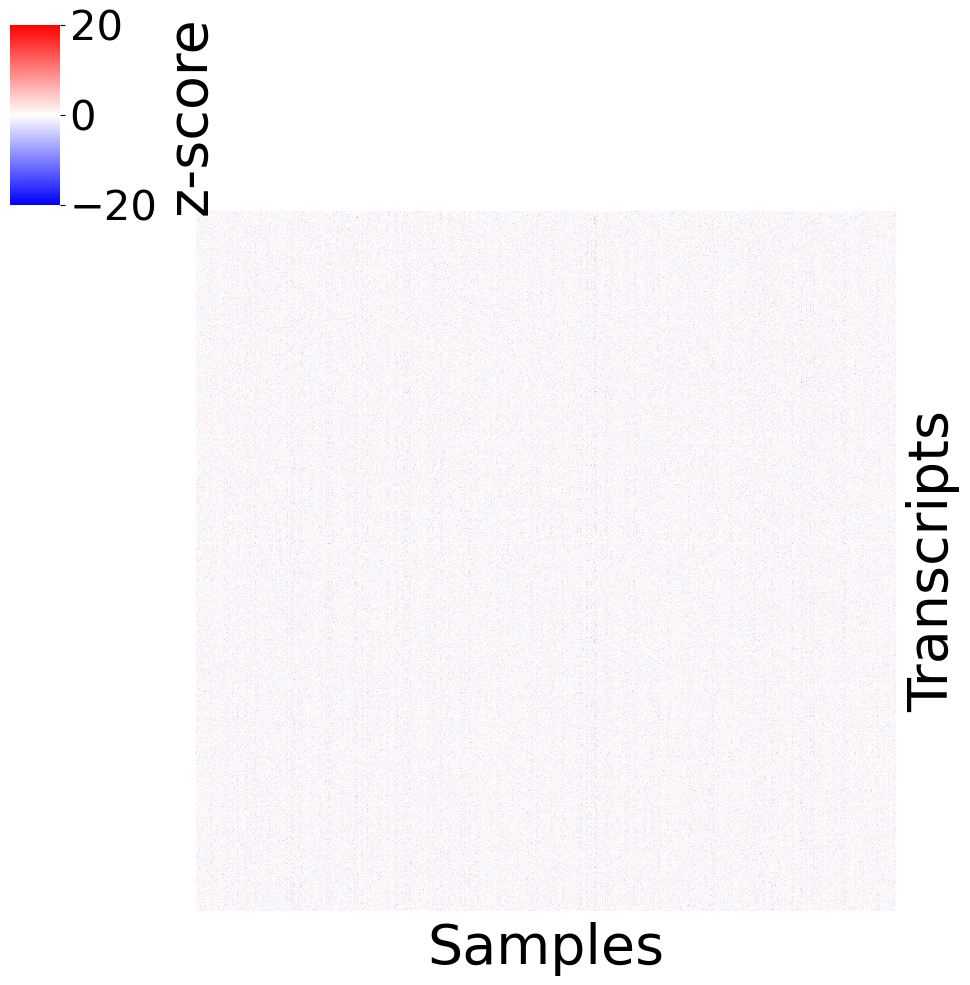

CPU times: user 1min 35s, sys: 16.7 s, total: 1min 52s
Wall time: 1min 52s


In [14]:
%%time
seaborn.clustermap(test, 
                   cmap='bwr', 
                   row_cluster=False, 
                   col_cluster=False, 
                   vmin=-20, vmax=20, 
                   cbar_kws={'label':'z-score'},
                   xticklabels=False, yticklabels=False, 
                  )
matplotlib.pyplot.show()

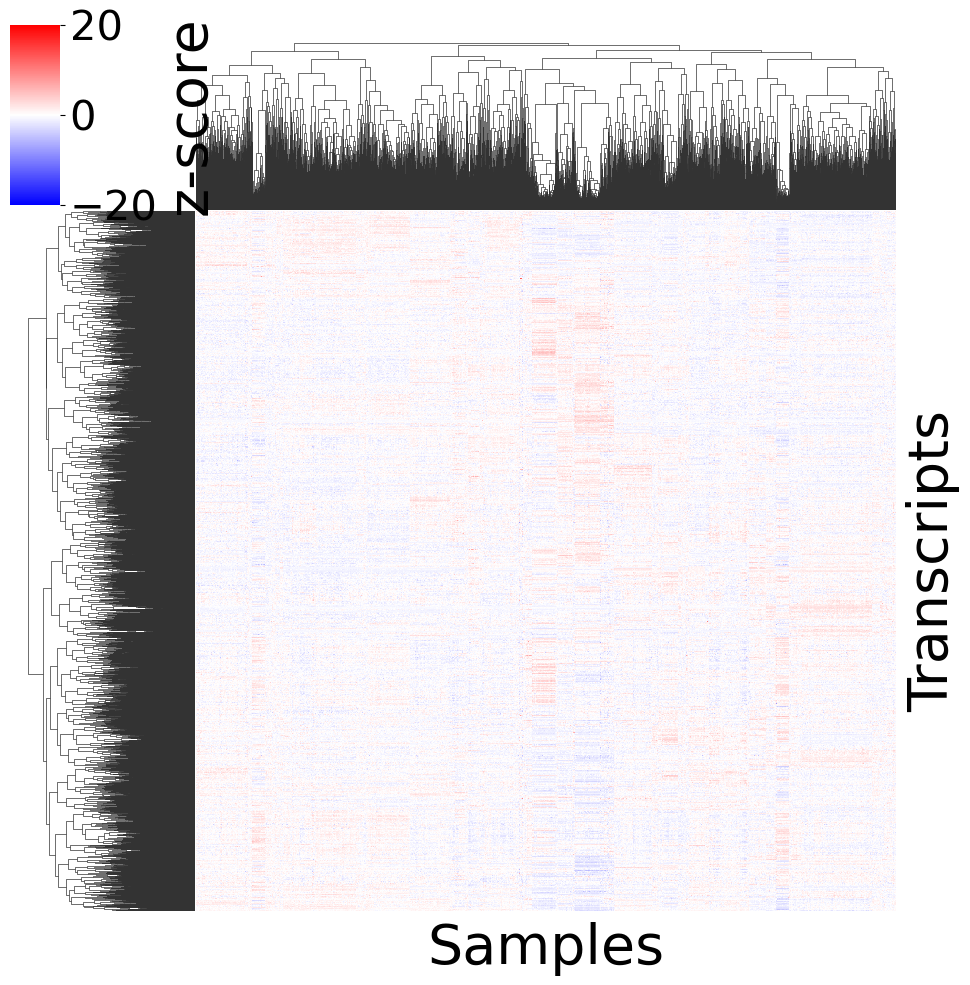

CPU times: user 1h 16min 44s, sys: 8.37 s, total: 1h 16min 52s
Wall time: 1h 16min 53s


In [15]:
%%time
linkage_method = 'complete'
distance_metric = 'cosine'

seaborn.clustermap(test, 
                   cmap='bwr', 
                   row_cluster=True, 
                   col_cluster=True, 
                   vmin=-20, vmax=20, 
                   cbar_kws={'label':'z-score'},
                   xticklabels=False, yticklabels=False, 
                   method=linkage_method, metric=distance_metric
                  )
matplotlib.pyplot.show()

In [16]:
this may be a good point to end, adrian 2023.01.27

SyntaxError: invalid syntax (581424365.py, line 1)

## dimensionality reduction

### UMAP

In [ ]:
%%time
runUmap = umap.UMAP(metric='correlation',
                    n_neighbors=5,
                    min_dist=0,
                    learning_rate=0.5
                   ).fit_transform
dr_umap = runUmap(test)
positionsu = pandas.DataFrame(dr_umap, columns=['X', 'Y'], index=test.index)

matplotlib.pyplot.plot(positionsu['X'], positionsu['Y'], 'o', alpha=1/10, markeredgecolor='None', ms=20, markevery=5)

matplotlib.pyplot.plot(positionsu.loc[iso1, 'X'], positionsu.loc[iso1, 'Y'], 'o', alpha=0.8, markeredgecolor='None', ms=20, color='tab:red', label='ATG7-201')
matplotlib.pyplot.plot(positionsu.loc[iso2, 'X'], positionsu.loc[iso2, 'Y'], 'o', alpha=0.9, markeredgecolor='None', ms=20, color='tab:orange', label='ATG7-202')

matplotlib.pyplot.legend()
matplotlib.pyplot.grid(ls=':')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

print(positionsu.shape)
positionsu

### tSNE

In [ ]:
%%time
tsne = MulticoreTSNE.MulticoreTSNE(n_jobs=20)
dr_tsne = tsne.fit_transform(test)
positionst = pandas.DataFrame(dr_tsne, columns=['X', 'Y'], index=test.index)

matplotlib.pyplot.plot(positionst['X'], positionst['Y'], 'o', alpha=1/10, markeredgecolor='None', ms=20)

matplotlib.pyplot.plot(positionst.loc[iso1, 'X'], positionst.loc[iso1, 'Y'], 'o', alpha=0.8, markeredgecolor='None', ms=20, color='tab:red', label='ATG7-201')
matplotlib.pyplot.plot(positionst.loc[iso2, 'X'], positionst.loc[iso2, 'Y'], 'o', alpha=0.9, markeredgecolor='None', ms=20, color='tab:orange', label='ATG7-202')

matplotlib.pyplot.legend()
matplotlib.pyplot.grid(ls=':')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

# cluster data

In [ ]:
import multiprocessing, multiprocessing.pool


In [ ]:
numberOfThreads = 4

print('about to enter a parallel world...')
hydra = multiprocessing.pool.Pool(numberOfThreads)
output = hydra.map(flexibleConverter,tags)
print('... all done.')

In [ ]:
%%time
all_ks = range(2, 20)
all_results = []

for k in all_ks:    
    print(k, end=' '),
    kmeans_results = sklearn.cluster.KMeans(n_clusters=k).fit(test)
    all_results.append(kmeans_results)
print()

In [ ]:
%%time

def information_retriever(test, result):
    
    # deterimine success
    df = pandas.DataFrame(result.labels_, columns=['label'], index=test.index)
    if df.loc[iso1, 'label'] == df.loc[iso2, 'label']:
        success = 0
    else:
        success = 1
    successes.append(success)
    print(success)
    
    # calculate and store goodness indices
    ss = sklearn.metrics.silhouette_score(test, result.labels_, metric='correlation')
    khi = sklearn.metrics.calinski_harabasz_score(test, result.labels_)
    dbi = sklearn.metrics.davies_bouldin_score(test, result.labels_)
    
    
    return [success, ss, khi, dbi]

for result in all_results:
    info = information_retriever(test, result)

In [ ]:
%%time 
#
# 2 to 10 takes 4 min at 10%
# 2 to 100 takes 1 h at 10%

all_ks = range(2, 20)
successes = []; all_ss = [];  all_khi = []; all_dbi = []
groupings = []
for k in all_ks:
    
    print(k, end=' '),
    
    kmeans = sklearn.cluster.KMeans(n_clusters=k).fit(test)
    
    # deterimine success
    #results = pandas.DataFrame(kmeans.labels_, columns=['label'], index=test.index)
    #if results.loc[iso1, 'label'] == results.loc[iso2, 'label']:
    #    success = 0
    #else:
    #    success = 1
    #successes.append(success)
    
    # calculate and store goodness indices
    #ss = sklearn.metrics.silhouette_score(test, kmeans.labels_, metric='correlation')
    #khi = sklearn.metrics.calinski_harabasz_score(test, kmeans.labels_)
    #dbi = sklearn.metrics.davies_bouldin_score(test, kmeans.labels_)
    #all_ss.append(ss); all_khi.append(khi); all_dbi.append(dbi)

    # store partitions
    #groupings.append(kmeans.labels_)
print()

In [ ]:
asd

In [ ]:
# silhouette: between -1 and 1, 0 being indiferent, 1 very good.
matplotlib.pyplot.plot(all_ks, all_ss, 'o-')
matplotlib.pyplot.xlabel('k')
matplotlib.pyplot.ylabel('silhouette')
matplotlib.pyplot.grid(alpha=0.5, ls=':')
#matplotlib.pyplot.xticks(all_ks)
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

In [ ]:
matplotlib.pyplot.plot(all_ks, all_khi, 'o-')
matplotlib.pyplot.xlabel('k')
matplotlib.pyplot.ylabel('KH')
matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.xticks(all_ks)
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

In [ ]:
# The minimum score is zero, with lower values indicating better clustering.
matplotlib.pyplot.plot(all_ks, all_dbi, 'o-')
matplotlib.pyplot.xlabel('k')
matplotlib.pyplot.ylabel('db')
matplotlib.pyplot.grid(alpha=0.5, ls=':')
#matplotlib.pyplot.xticks(all_ks)
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

In [ ]:
matplotlib.pyplot.plot(all_ks, successes, 'o-')
matplotlib.pyplot.xlabel('k')
matplotlib.pyplot.ylabel('success')
matplotlib.pyplot.grid(alpha=0.5, ls=':')
#matplotlib.pyplot.xticks(all_ks)
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

## heatmap with labels

In [ ]:
print(test.index.get_loc(iso1))
print(test.index.get_loc(iso2))

In [ ]:
observed_best_k = 4
best_index = all_ks.index(observed_best_k)
labels = groupings[best_index]

print(set(labels))

print('ATG7-201 is in cluster {}'.format(labels[test.index.get_loc(iso1)]))
print('ATG7-202 is in cluster {}'.format(labels[test.index.get_loc(iso2)]))

In [ ]:
%%time

cmap = matplotlib.pyplot.cm.get_cmap('tab20')
k_colors = cmap(labels)

linkage_method = 'complete'
distance_metric = 'correlation'

clustergrid = seaborn.clustermap(test, 
                   cmap='bwr', 
                   row_cluster=True, 
                   col_cluster=True, 
                   vmin=-20, vmax=20, 
                   cbar_kws={'label':'z-score'},
                   xticklabels=False, yticklabels=False, 
                   method=linkage_method, metric=distance_metric,
                   row_colors=k_colors
                  )

# adding where isoforms fall
loc1 = clustergrid.dendrogram_row.reordered_ind.index(test.index.get_loc(iso1))
loc2 = clustergrid.dendrogram_row.reordered_ind.index(test.index.get_loc(iso2))
ax = clustergrid.ax_heatmap
ax.add_patch(matplotlib.patches.Arrow(test.shape[1], loc1, dx=-100, dy=0, color='gold', width=100))
ax.add_patch(matplotlib.patches.Arrow(test.shape[1], loc2, dx=-100, dy=0, color='skyblue', width=100))
matplotlib.pyplot.show()

In [ ]:
iso1clusterlabel = labels[test.index.get_loc(iso1)]
iso2clusterlabel = labels[test.index.get_loc(iso2)]
print(iso1clusterlabel, iso2clusterlabel)

In [ ]:
# only the two isoforms
print(iso1)
print(iso2)
seaborn.set(font_scale=1) 
seaborn.clustermap(
    test.iloc[[test.index.get_loc(iso1), test.index.get_loc(iso2)], clustergrid.dendrogram_col.reordered_ind], 
    cmap='bwr', 
    vmin=-20, vmax=20,
    row_cluster=False, col_cluster=False, 
    cbar_kws={'label':'z-score'},
    xticklabels=False, yticklabels=True,  
    row_colors=cmap([iso1clusterlabel, iso2clusterlabel])
)
matplotlib.pyplot.show()

In [ ]:
# only the two clusters
cluster_indexes = []
cluster_labels = []
iso1_cluster_names = []; iso2_cluster_names = []
for row in clustergrid.dendrogram_row.reordered_ind:
    if labels[row] == iso1clusterlabel:
        cluster_indexes.append(row); cluster_labels.append(iso1clusterlabel)
        iso1_cluster_names.append(test.index[row])
    if labels[row] == iso2clusterlabel:
        cluster_indexes.append(row); cluster_labels.append(iso2clusterlabel)
        iso2_cluster_names.append(test.index[row])

seaborn.clustermap(
    test.iloc[cluster_indexes, clustergrid.dendrogram_col.reordered_ind], 
    cmap='bwr', 
    vmin=-20, vmax=20,
    row_cluster=False, col_cluster=False, 
    cbar_kws={'label':'z-score'},
    xticklabels=False, yticklabels=False,  
    row_colors=cmap(cluster_labels)
)
matplotlib.pyplot.show()

print(len(iso1_cluster_names), len(iso2_cluster_names))
print(iso1 in iso1_cluster_names, iso1 in iso2_cluster_names)
print(iso2 in iso2_cluster_names, iso2 in iso1_cluster_names)

In [ ]:
linkage_method = 'complete'
distance_metric = 'correlation'

twoc = test.iloc[cluster_indexes, clustergrid.dendrogram_col.reordered_ind]

clustergrid = seaborn.clustermap(
    twoc, 
    cmap='bwr', 
    row_cluster=True, 
    col_cluster=False, 
    vmin=-20, vmax=20, 
    cbar_kws={'label':'z-score'},
    xticklabels=False, yticklabels=False, 
    method=linkage_method, metric=distance_metric,
    row_colors=cmap(cluster_labels)
)

# adding where isoforms fall
loc1 = clustergrid.dendrogram_row.reordered_ind.index(twoc.index.get_loc(iso1))
loc2 = clustergrid.dendrogram_row.reordered_ind.index(twoc.index.get_loc(iso2))
ax = clustergrid.ax_heatmap
ax.add_patch(matplotlib.patches.Arrow(twoc.shape[1], loc1, dx=-100, dy=0, color='gold', width=100))
ax.add_patch(matplotlib.patches.Arrow(twoc.shape[1], loc2, dx=-100, dy=0, color='skyblue', width=100))
matplotlib.pyplot.show()